In [1]:
from kan.hypothesis import *
from torchvision import transforms
import torch
import torch.nn.functional as F
from kan import *
import h5py
import copy
import sympy as sp
dtype = torch.get_default_dtype()

In [2]:
data_dir = "./"
filename = "sg2-data.h5"
checkpoint_dir = "./saved_models/"
log_dir = './logs/'
band_idx = 0
gidxs = [1, 2, 3, 4]
only_obstructed = False
only_topological = False
binary_classification = False#True
no_penalize_last = True
bias = False
numrs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
file = h5py.File(data_dir + filename, 'r')
print("file keys: ", file['sg2/1/'].keys())

file keys:  <KeysViewHDF5 ['epsilon_Gs-gidx=1', 'epsilon_Gs-gidx=2', 'epsilon_Gs-gidx=3', 'epsilon_Gs-gidx=4', 'frequencies-gidx=1-mode=tm', 'frequencies-gidx=2-mode=tm', 'frequencies-gidx=3-mode=tm', 'frequencies-gidx=4-mode=tm', 'symmetry-gidx=1-mode=tm', 'symmetry-gidx=2-mode=tm', 'symmetry-gidx=3-mode=tm', 'symmetry-gidx=4-mode=tm']>


In [4]:
nGs = 10
gidxs = [1, 2, 3, 4]
wps = ['1a', '1b', '1c', '1d']
wps2 = ['1a', '1c', '1b', '1d'] # switch 1b and 1c due to convention of how Gvectors are stored

symmetry_data = torch.zeros(10000 * len(gidxs) * len(wps))
input_data = torch.zeros(10000 * len(gidxs) * len(wps), nGs)

In [5]:
for (widx, (wp1, wp2)) in enumerate(zip(wps, wps2)):
    print(f"Wyckoff index: {widx}")
    sym_vec_phases = file[f'sg2/symmetry_vector_phases/{wp1}'][()]
    epsilon_G_phases = file[f'sg2/epsilon_G_phases/{wp2}'][()].real
    for gidx in gidxs:
        print(f"gidx: {gidx}")
        for id in range(1, 10001):
            real_id = (id-1) + (gidx-1)*10000 + len(gidxs)*10000*widx
            if (id % 1000 == 0): 
                print(id)
            symmetry_before_aug = file[f'sg2/{id}/symmetry-gidx={gidx}-mode=tm'][()][band_idx]
            if band_idx == 0:
                symmetry_data[real_id] =  sym_vec_phases[symmetry_before_aug] - 8
            else: 
                symmetry_data[real_id] =  sym_vec_phases[symmetry_before_aug] 

            fourier_data_before_aug = file[f'sg2/{id}/epsilon_Gs-gidx={gidx}'][()][0:nGs].real
            fourier_data = fourier_data_before_aug * epsilon_G_phases
            input_data[real_id, :] = torch.tensor([*fourier_data])


Wyckoff index: 0
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Wyckoff index: 1
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Wyckoff index: 2
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Wyckoff index: 3
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000

In [6]:
shuffled_indices = torch.randperm(10000 * len(gidxs) * len(wps))
input_data_shuffled = input_data[shuffled_indices, :]
symmetry_data_shuffled = symmetry_data[shuffled_indices]

In [7]:
dataset_kan = {}
n_train = 80000#int(input_data_shuffled.shape[0]*2/3)
nGs = 10
nGstart = 1
dataset_kan['train_input'] = input_data_shuffled[0:n_train, [*range(nGstart, nGs)]].to(device)
dataset_kan['test_input'] = input_data_shuffled[n_train:, [*range(nGstart, nGs)]].to(device)
dataset_kan['train_label'] = symmetry_data_shuffled[0:n_train].long().to(device)
dataset_kan['test_label'] = symmetry_data_shuffled[n_train:].long().to(device)

In [105]:
model = KAN.loadckpt('./band1');

In [27]:
model.prune_edge(threshold=0.04)

saving model version 1.6


In [106]:
print((model(dataset_kan['train_input']).argmax(1) == dataset_kan['train_label']).sum()/80000)
print((model(dataset_kan['test_input']).argmax(1) == dataset_kan['test_label']).sum()/80000)

tensor(0.9971, device='cuda:0')
tensor(0.9970, device='cuda:0')


In [11]:
dataset_kan['train_label']

tensor([1, 4, 4,  ..., 6, 4, 2], device='cuda:0')

In [131]:
n_class = 16
if band_idx == 0:
    n_class = 8
#model = KAN(width=[9, 24, n_class], grid=5, k=1, seed=1, device=device)
lr = 1
def train_acc():
    return torch.mean((torch.argmax(model(dataset_kan['train_input']), dim=1) == dataset_kan['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset_kan['test_input']), dim=1) == dataset_kan['test_label']).type(dtype))
    
results = model.fit(dataset_kan, opt="LBFGS", steps=100, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(), lr=lr);
model.attribute()

| train_loss: 3.30e-01 | test_loss: 3.28e-01 | reg: 0.00e+00 | : 100%|█| 100/100 [00:46<00:00,  2.14

saving model version 1.7


In [132]:
print("Train accuracy: ", round(results['train_acc'][-1]*100, 2),  " Test accuracy: ", round(results['test_acc'][-1]*100, 2))

Train accuracy:  98.86  Test accuracy:  98.92


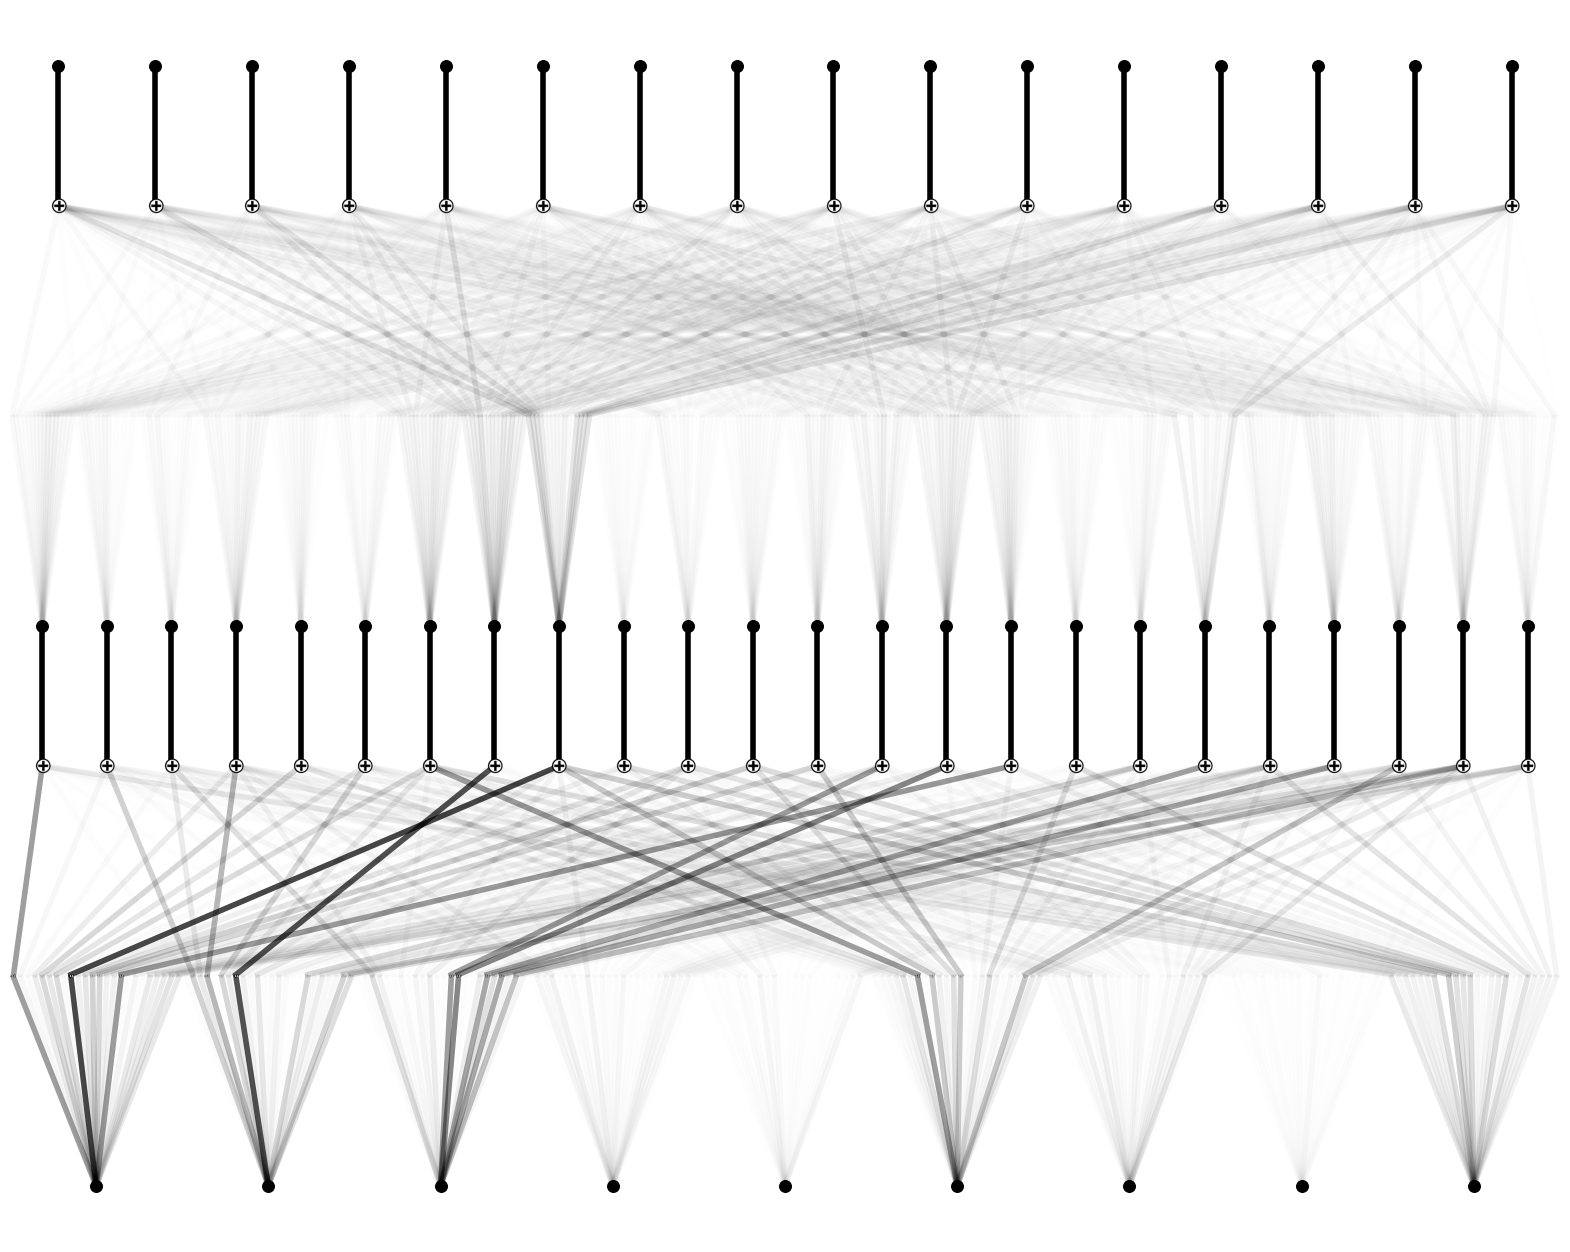

In [47]:
model.plot(scale=2)
#plt.savefig("./figures/TM-Band2-9774-9602.pdf")

In [121]:
model = model.prune_input(threshold=0.25)

keep: [True, True, True, False, False, False, False, False, False]
saving model version 1.2


In [122]:
model = model.prune_node(threshold=0.2)

saving model version 1.3


In [46]:
model.prune_edge(threshold=0.005)

saving model version 1.7


In [124]:
print((model(dataset_kan['train_input']).argmax(1) == dataset_kan['train_label']).sum()/80000)
print((model(dataset_kan['test_input']).argmax(1) == dataset_kan['test_label']).sum()/80000)

tensor(0.2436, device='cuda:0')
tensor(0.2427, device='cuda:0')


In [123]:
model = model.refine(1)

saving model version 1.4


In [39]:
model.width_in

[3, 4, 8]

In [113]:
model.grid

10

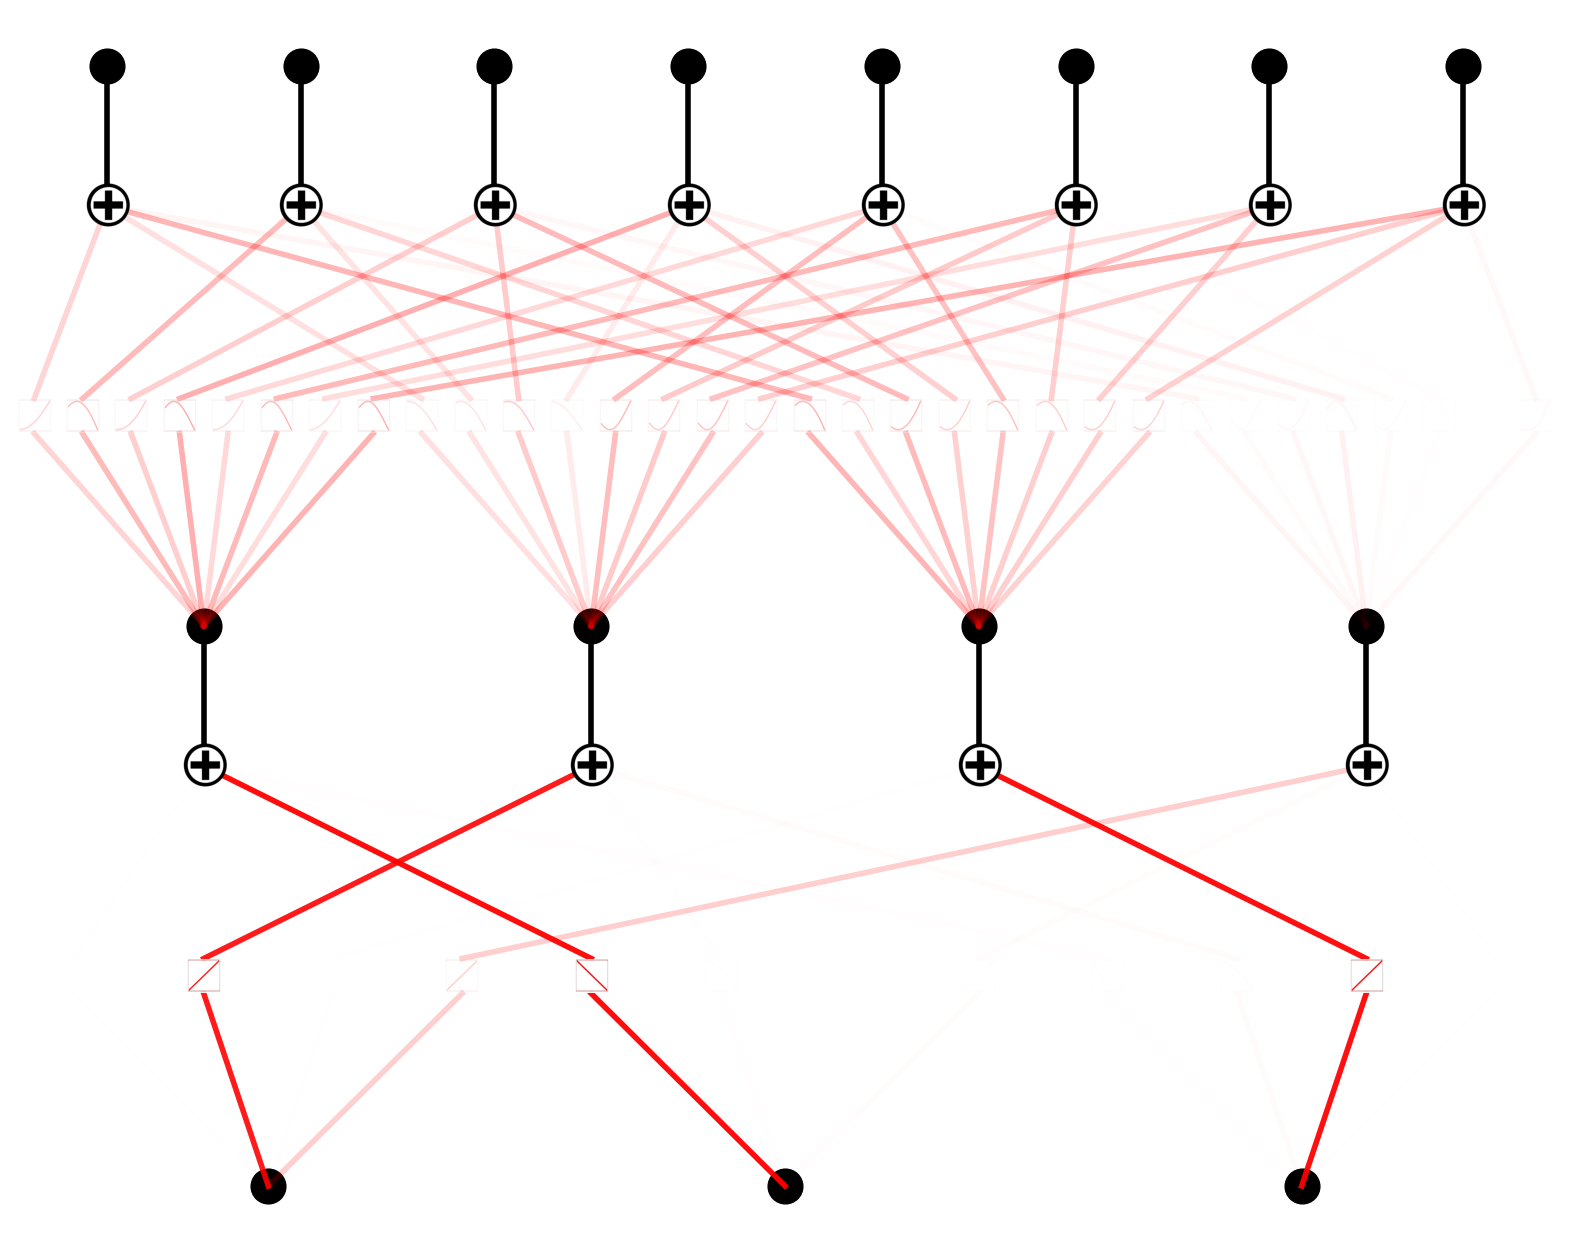

In [133]:
model.plot(scale=2)
#plt.savefig("./figures/TM-Band1-100-99-prunedinput.pdf")

In [49]:
#model.saveckpt("./band2")

(array([-0.99979985, -0.9997963 , -0.99963665, ...,  0.9995364 ,
         0.9997963 ,  0.9997963 ], dtype=float32),
 array([ 69.77423 ,  69.774315,  69.77788 , ..., -84.43941 , -84.43067 ,
        -84.43067 ], dtype=float32))

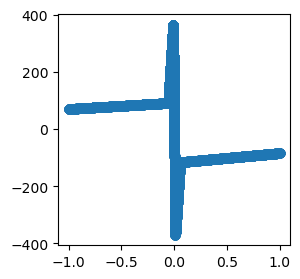

In [88]:
model.get_fun(0, 1, 0)

In [96]:
model.width_out

[3, 24, 8]

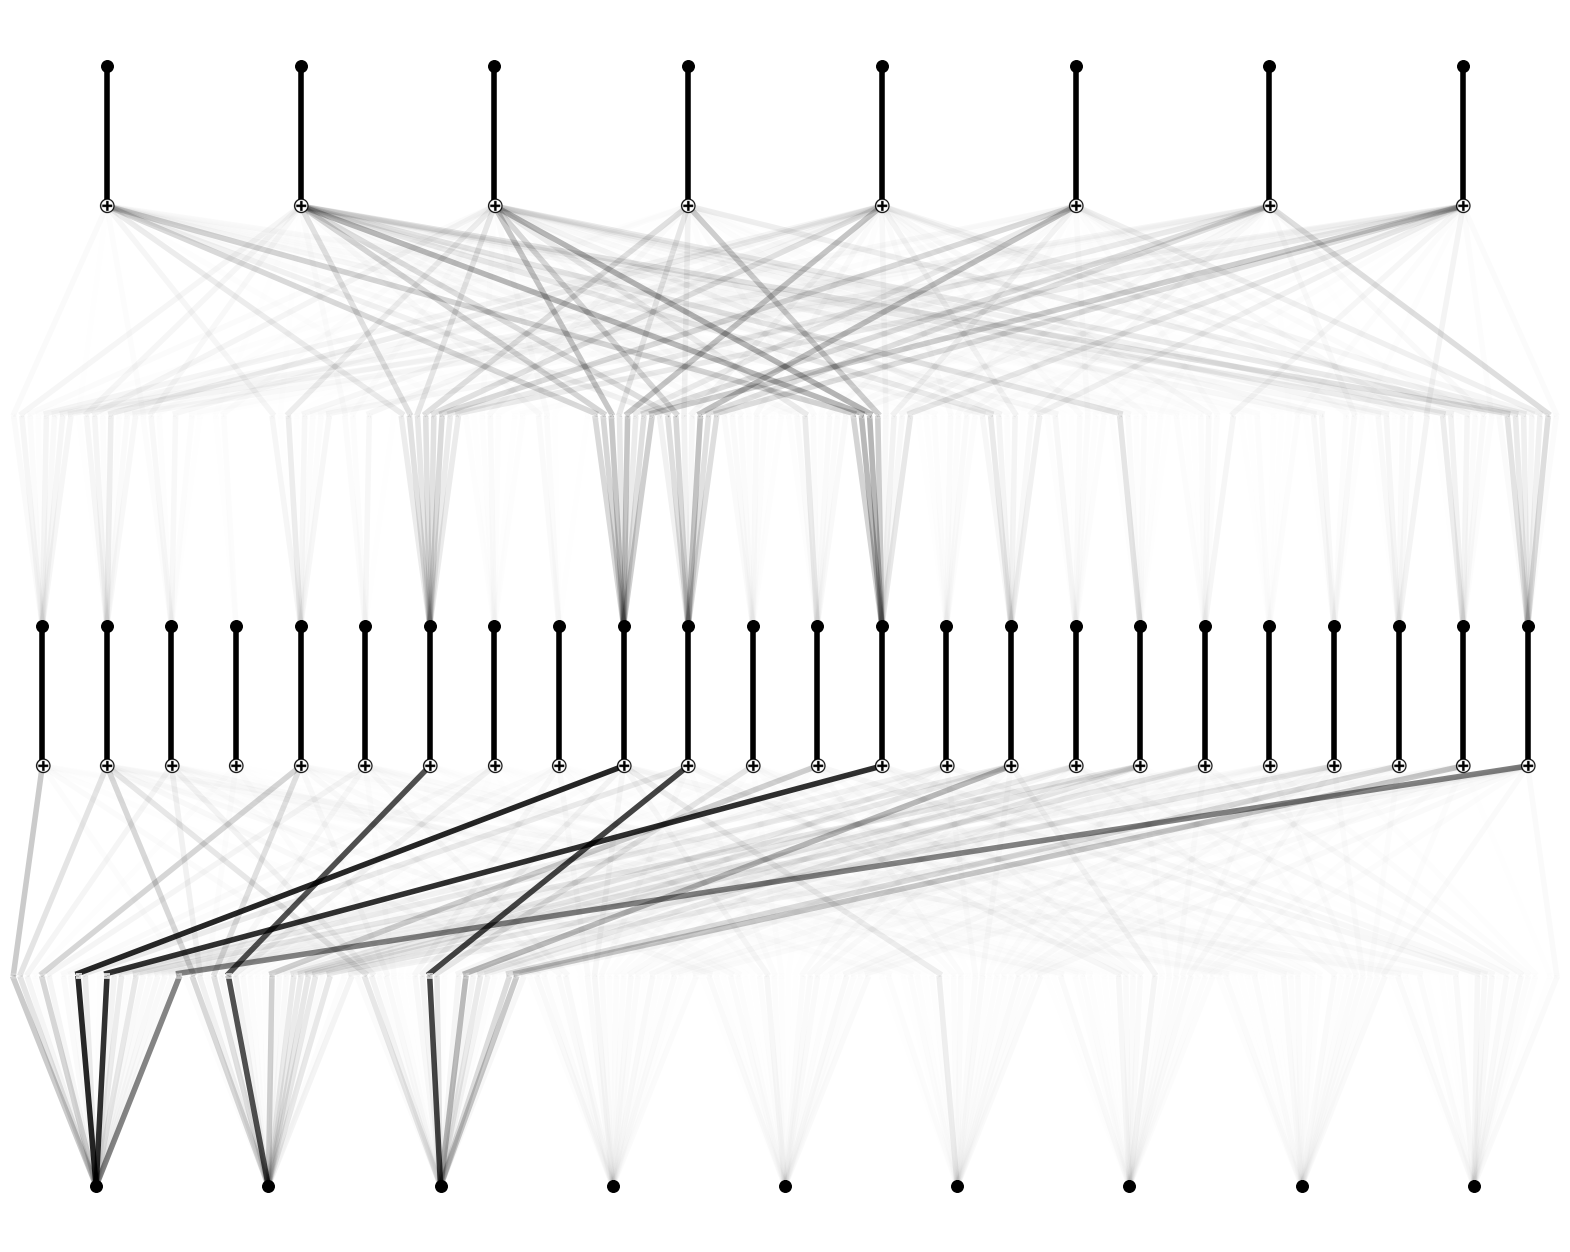

In [120]:
model.plot(scale=2)

In [98]:
formula = modelprime_band1.symbolic_formula()[0][0]

In [99]:
formula

59.5086381874737*(-0.00729505837322666*tanh(10.0*x_1 - 1.49011611938477e-7) + 0.00249787212099764*sign(0.199759855866432 - 7.28136014938354*x_3) + 0.76600827860639*sign(-10.0*x_2 - 1.49011611938477e-7) + 1)**2 - 6.33312660589962*(-0.173765217086719*sign(0.204079851508141 - 8.99600028991699*x_3) - 0.943512589839331*sign(0.0159998517483473*x_1 + 1.16415321826935e-10) - 1 - 0.177451365994464*exp(-100.0*(-x_2 - 0.0599999845027924)**2))**2 - 1.60937297344208*sin(8.31608432260447*sin(0.844879865646362*x_1 + 5.41784000396729) - 16.0328637669131*sin(0.455919861793518*x_2 + 8.45991992950439) - 1.68210999159174*sign(0.0199998524039984*x_3 + 1.16415321826935e-10) + 18.8016828447425) - 2865.80737304688*sin(0.0131305208747108*sin(1.3239198923111*x_1 + 1.60023987293243) - 0.00272012146226458*sign(-10.0*x_2 - 1.49011611938477e-7) + 0.314176903728956*sign(0.0199998524039984*x_3 + 1.16415321826935e-10) + 5.10464257230916) - 12.0287580490112*sin(1.86630141461762*tanh(9.99997997283936*x_1 + 1.49011611938

In [35]:
#model.saveckpt("./band1-prunedinput")

In [37]:
#modelprime_band1 = KAN.loadckpt('./band1-prunedinput');

In [16]:
modelprime_band1 = modelprime_band1.prune_node(threshold=0.01)

saving model version 1.2


In [58]:
model.prune_edge(threshold=0.001)

saving model version 1.10


In [118]:
model = KAN.loadckpt('./band1');

In [17]:
print((modelprime_band1(dataset_kan['train_input']).argmax(1) == dataset_kan['train_label']).sum()/80000)
print((modelprime_band1(dataset_kan['test_input']).argmax(1) == dataset_kan['test_label']).sum()/80000)

tensor(1., device='cuda:0')
tensor(0.9941, device='cuda:0')


In [85]:
print((modelprime_band1(dataset_kan['train_input']).argmax(1) == dataset_kan['train_label']).sum()/80000)
print((modelprime_band1(dataset_kan['test_input']).argmax(1) == dataset_kan['test_label']).sum()/80000)

tensor(0.9804, device='cuda:0')
tensor(0.9797, device='cuda:0')


In [119]:
print((model(dataset_kan['train_input']).argmax(1) == dataset_kan['train_label']).sum()/80000)
print((model(dataset_kan['test_input']).argmax(1) == dataset_kan['test_label']).sum()/80000)

tensor(0.9971, device='cuda:0')
tensor(0.9970, device='cuda:0')


In [54]:
print((model1(dataset_kan['train_input']).argmax(1) == dataset_kan['train_label']).sum()/80000)
print((model1(dataset_kan['test_input']).argmax(1) == dataset_kan['test_label']).sum()/80000)

tensor(0.1745, device='cuda:0')
tensor(0.1789, device='cuda:0')


In [62]:
(modelprime_band1(dataset_kan['test_input']).argmax(1) == dataset_kan['test_label']).sum()/80000

tensor(0.9957, device='cuda:0')

In [81]:
model= model.prune_input(threshold=0.2)

NameError: name 'model1' is not defined

In [87]:
model = model.prune_input(threshold=0.15)

keep: [True, True, True, False, False, False, False, False, False]
saving model version 1.2


In [32]:
model = KAN(width=[3,5,1], grid=5, k=3, noise_scale=0.3, seed=2)

checkpoint directory created: ./model
saving model version 0.0


In [33]:
f = lambda x: 1 * x[:,[0]]**2 + 0.3 * x[:,[1]]**2 + 0.0 * x[:,[2]]**2
dataset = create_dataset(f, n_var=3)
model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);

| train_loss: 1.14e-02 | test_loss: 1.14e-02 | reg: 4.00e+00 | : 100%|█| 20/20 [00:06<00:00,  2.99it

saving model version 0.1


In [34]:
model.attribute()

In [35]:
model.feature_score

tensor([0.9648, 0.2703, 0.0052], grad_fn=<MeanBackward1>)

In [36]:
model.edge_scores

[tensor([[9.6476e-01, 2.7028e-01, 5.1424e-03],
         [6.2842e-06, 4.5592e-07, 1.8812e-07],
         [2.0502e-06, 1.2963e-06, 2.2973e-06],
         [1.4259e-05, 2.6286e-06, 1.2653e-06],
         [2.8800e-05, 1.8042e-05, 2.7087e-05]], grad_fn=<MeanBackward1>),
 tensor([[9.9967e-01, 6.3458e-06, 3.4115e-06, 1.4819e-05, 4.4079e-05]],
        grad_fn=<MeanBackward1>)]

# Inverse Design

In [19]:
indices = (dataset_kan['train_label'] == 0).nonzero(as_tuple=True)[0]
inverse_design_params = torch.zeros((100, 9));

In [22]:
?torch.optim

Type:        module
String form: <module 'torch.optim' from '/state/partition1/llgrid/pkg/anaconda/python-ML-2025a/lib/python3.10/site-packages/torch/optim/__init__.py'>
File:        /state/partition1/llgrid/pkg/anaconda/python-ML-2025a/lib/python3.10/site-packages/torch/optim/__init__.py
Docstring:  
:mod:`torch.optim` is a package implementing various optimization algorithms.

Most commonly used methods are already supported, and the interface is general
enough, so that more sophisticated ones can also be easily integrated in the
future.

In [23]:
model.eval()  # Set model to evaluation mode
#target_category = 0
for (j, i) in enumerate(indices[0:10]):
    print(f"Doing gradient descent on index: {i}");
    x = dataset_kan['train_input'][i:i+1, :].cpu().numpy()
    input_tensor = torch.tensor(x, requires_grad=True, device=device).to(device)  # Adjust size to match model input
    optimizer = torch.optim.AdamW([input_tensor], lr=1e-3)
    num_iterations = 100
    for i in range(num_iterations):
        optimizer.zero_grad()
        output = model(input_tensor)
        target_score = (output[0, :]*torch.tensor((7, -1,-1, -1, -1, -1, -1, -1)).cuda()).sum()
        
        loss = -target_score 
        loss.backward()
        input_tensor.grad[torch.isnan(input_tensor.grad)] = 0
        optimizer.step()
        if (i + 1) % 10 == 0 or i == 0:
            print(f"Iteration {i + 1}/{num_iterations}, Loss: {-loss.item()}")
    inverse_design_params[j, :] = input_tensor

Doing gradient descent on index: 24
Iteration 1/100, Loss: 600.6814575195312
Iteration 10/100, Loss: 602.2506103515625
Iteration 20/100, Loss: 603.9937744140625
Iteration 30/100, Loss: 605.7369384765625
Iteration 40/100, Loss: 607.479736328125
Iteration 50/100, Loss: 609.2225341796875
Iteration 60/100, Loss: 610.9649658203125
Iteration 70/100, Loss: 612.7071533203125
Iteration 80/100, Loss: 614.4491577148438
Iteration 90/100, Loss: 616.1907958984375
Iteration 100/100, Loss: 617.9322509765625
Doing gradient descent on index: 27
Iteration 1/100, Loss: 2307.521484375
Iteration 10/100, Loss: 2492.107421875
Iteration 20/100, Loss: 2505.331787109375
Iteration 30/100, Loss: 2486.044921875
Iteration 40/100, Loss: 2502.1318359375
Iteration 50/100, Loss: 2520.0400390625
Iteration 60/100, Loss: 2513.67724609375
Iteration 70/100, Loss: 2486.123046875
Iteration 80/100, Loss: 2500.04541015625
Iteration 90/100, Loss: 2511.397705078125
Iteration 100/100, Loss: 2514.368408203125
Doing gradient descent 

In [49]:
inverse_design_params_checked = inverse_design_params[(model(inverse_design_params.to(device)).argmax(1) == 0).cpu()];

In [51]:
with h5py.File('./inverse_design_smooth/inverse_design_params-1.h5', 'w') as f:
    # Save the array to the file with the key 'dataset'
    f.create_dataset('inverse_design_params', data=inverse_design_params_checked.detach().numpy())

print("Data saved to example.h5")

Data saved to example.h5


# Original data

In [67]:
with h5py.File('./inverse_design_smooth/original_design_params.h5', 'w') as f:
    # Save the array to the file with the key 'dataset'
    culled_original = dataset_kan['train_input'][indices[0:100]][(model(inverse_design_params.to(device)).argmax(1) == 0).cpu()]
    f.create_dataset('original_design_params', data = culled_original.cpu().detach().numpy())

In [66]:
culled_original.cpu().detach().numpy();

# Inverse design with symbolic regression

In [ ]:
#model.fix_symbolic(0,1,0,'x^2')

In [107]:
model.attribute()
model = model.prune_input(threshold=0.25)

keep: [True, True, True, False, False, False, False, False, False]
saving model version 1.2


In [90]:
lib = ['x','x^2','x^3','x^4','exp','tanh','sin']
model.auto_symbolic(lib=lib, weight_simple=0)

fixing (0,0,0) with x^4, r2=0.2357446849346161, c=3
fixing (0,0,1) with tanh, r2=0.32718387246131897, c=3
fixing (0,0,2) with sin, r2=0.9894744753837585, c=2
fixing (0,0,3) with tanh, r2=0.3127177655696869, c=3
fixing (0,1,0) with tanh, r2=0.23705145716667175, c=3
fixing (0,1,1) with sin, r2=0.9890695214271545, c=2
fixing (0,1,2) with sin, r2=0.1971285492181778, c=2
fixing (0,1,3) with sin, r2=0.40563830733299255, c=2
fixing (0,2,0) with sin, r2=0.4372725188732147, c=2
fixing (0,2,1) with sin, r2=0.6439269185066223, c=2
fixing (0,2,2) with tanh, r2=0.26371899247169495, c=3
fixing (0,2,3) with tanh, r2=0.26771143078804016, c=3
fixing (1,0,0) with tanh, r2=0.9965795278549194, c=3
fixing (1,0,1) with x^2, r2=0.9811980724334717, c=2
fixing (1,0,2) with tanh, r2=0.9927680492401123, c=3
fixing (1,0,3) with tanh, r2=0.9958062767982483, c=3
fixing (1,0,4) with x^2, r2=0.9922096133232117, c=2
fixing (1,0,5) with tanh, r2=0.9957428574562073, c=3
fixing (1,0,6) with tanh, r2=0.9958688616752625, c

In [129]:
model.auto_symbolic(a_range=(-10, 10), b_range=(-10, 10), weight_simple=0)

fixing (0,0,0) with cos, r2=0.9999578595161438, c=2
fixing (0,0,1) with x^1.5, r2=1.0000003576278687, c=4
fixing (0,0,2) with x^2, r2=0.9999691843986511, c=2
fixing (0,0,3) with arctan, r2=1.0000004768371582, c=4
fixing (0,1,0) with arcsin, r2=1.0000003576278687, c=4
fixing (0,1,1) with sin, r2=0.9999839067459106, c=2
fixing (0,1,2) with sin, r2=0.999854564666748, c=2
fixing (0,1,3) with tanh, r2=0.999998927116394, c=3
fixing (0,2,0) with sin, r2=0.9999278783798218, c=2
fixing (0,2,1) with tanh, r2=0.9999933242797852, c=3
fixing (0,2,2) with arcsin, r2=1.0000004768371582, c=4
fixing (0,2,3) with gaussian, r2=0.9999954700469971, c=3
fixing (1,0,0) with sin, r2=0.974365770816803, c=2
fixing (1,0,1) with cos, r2=0.9753331542015076, c=2
fixing (1,0,2) with cos, r2=0.9748666882514954, c=2
fixing (1,0,3) with sin, r2=0.9744558334350586, c=2
fixing (1,0,4) with cos, r2=0.9747285842895508, c=2
fixing (1,0,5) with sin, r2=0.9745556712150574, c=2
fixing (1,0,6) with sin, r2=0.974476158618927, c=

In [134]:
print((model(dataset_kan['train_input']).argmax(1) == dataset_kan['train_label']).sum()/80000)
print((model(dataset_kan['test_input']).argmax(1) == dataset_kan['test_label']).sum()/80000)

tensor(0.9886, device='cuda:0')
tensor(0.9892, device='cuda:0')


In [139]:
formulas = model.symbolic_formula()[0]

In [140]:
formulas[0]

-815.77392578125*sin(-37.5039167097648*(0.00987200119391045*x_1 + 1)**(3/2) + 0.266468853353171*sin(0.0825537815690041*x_2 + 4.83531093597412) + 0.0140877480271029*tanh(0.632036209106445*x_3 - 0.723158657550812) + 29.3748825038957) + 1113.05102539063*sin(0.0406179238234023*sin(0.252682119607925*x_3 + 7.69797992706299) + 0.0445160471999606*cos(0.164625287055969*x_1 + 9.56911468505859) + 21.7216146115386*asin(0.024462416768074*x_2 + 0.0681736692786217) - 9.90190988653518) - 161.877899169922*sin(0.444919425171289*tanh(0.201424539089203*x_2 - 0.632489502429962) + 28.2102148083763*atan(0.0320638790726662*x_1 - 0.125709563493729) - 3.58540876160104 + 0.0655830702785045*exp(-1.59873721783335*(1 - 0.381196404521501*x_3)**2)) - 2587.39135742188*cos(-0.000487216230360282*(-0.938721792690413*x_1 - 1)**2 + 0.00219272406668837*sin(0.446559876203537*x_2 + 1.44320249557495) + 11.5035705805184*asin(0.0538896061480045*x_3 + 0.0454225949943066) + 9.19830847967697) - 2374.43255615234

In [141]:
formulas[1]

-877.749145507813*sin(-53.2319718364244*(0.00987200119391045*x_1 + 1)**(3/2) + 0.37821816336551*sin(0.0825537815690041*x_2 + 4.83531093597412) + 0.0199957410320861*tanh(0.632036209106445*x_3 - 0.723158657550812) + 45.2218687325199) - 2244.98754882813*cos(-0.000510056145622062*(-0.938721792690413*x_1 - 1)**2 + 0.00229551545325321*sin(0.446559876203537*x_2 + 1.44320249557495) + 12.0428395147094*asin(0.0538896061480045*x_3 + 0.0454225949943066) + 9.20778763900144) - 3208.01000976563*cos(0.0564585334515875*sin(0.252682119607925*x_3 + 7.69797992706299) + 0.061876888412582*cos(0.164625287055969*x_1 + 9.56911468505859) + 30.1928407394732*asin(0.024462416768074*x_2 + 0.0681736692786217) - 11.7963014179996) - 52.4250869750977*cos(0.847314535753483*tanh(0.201424539089203*x_2 - 0.632489502429962) + 53.7241660209893*atan(0.0320638790726662*x_1 - 0.125709563493729) + 1.44122623106386 + 0.124897870496271*exp(-1.59873721783335*(1 - 0.381196404521501*x_3)**2)) - 5877.2123298645

In [142]:
formulas[2]

-931.888366699219*sin(-49.9354466040122*(0.00987200119391045*x_1 + 1)**(3/2) + 0.354796041736758*sin(0.0825537815690041*x_2 + 4.83531093597412) + 0.0187574539166735*tanh(0.632036209106445*x_3 - 0.723158657550812) + 41.9041184380585) + 95.7817077636719*sin(0.549719684669448*tanh(0.201424539089203*x_2 - 0.632489502429962) + 34.8550985000211*atan(0.0320638790726662*x_1 - 0.125709563493729) - 2.69523146621391 + 0.0810310871440914*exp(-1.59873721783335*(1 - 0.381196404521501*x_3)**2)) + 2507.80688476563*cos(-0.000439312904072413*(-0.938721792690413*x_1 - 1)**2 + 0.00197713441700005*sin(0.446559876203537*x_2 + 1.44320249557495) + 10.372534172748*asin(0.0538896061480045*x_3 + 0.0454225949943066) + 9.25619653706877) + 3277.642578125*cos(0.0243790535264821*sin(0.252682119607925*x_3 + 7.69797992706299) + 0.0267187240340916*cos(0.164625287055969*x_1 + 9.56911468505859) + 13.0374070225423*asin(0.024462416768074*x_2 + 0.0681736692786217) - 10.6153725798769) + 4805.33856201172

In [143]:
formulas[3]

-810.228576660156*sin(-30.7956065800145*(0.00987200119391045*x_1 + 1)**(3/2) + 0.218805679342692*sin(0.0825537815690041*x_2 + 4.83531093597412) + 0.0115678783418394*tanh(0.632036209106445*x_3 - 0.723158657550812) + 22.615330530832) - 1143.02587890625*sin(0.0974453282257008*sin(0.252682119607925*x_3 + 7.69797992706299) + 0.106797207301168*cos(0.164625287055969*x_1 + 9.56911468505859) + 52.1117198066638*asin(0.024462416768074*x_2 + 0.0681736692786217) - 11.9421413940765) - 193.399353027344*sin(0.630683866758034*tanh(0.201424539089203*x_2 - 0.632489502429962) + 39.9886504181559*atan(0.0320638790726662*x_1 - 0.125709563493729) - 1.99236301500927 + 0.0929655618906438*exp(-1.59873721783335*(1 - 0.381196404521501*x_3)**2)) + 2459.27172851563*cos(-0.000439838921216965*(-0.938721792690413*x_1 - 1)**2 + 0.00197950176517213*sin(0.446559876203537*x_2 + 1.44320249557495) + 10.3849538644*asin(0.0538896061480045*x_3 + 0.0454225949943066) + 9.25767130709053) + 507.985260009766

In [144]:
formulas[4]

858.428955078125*sin(-83.2698949709144*(0.00987200119391045*x_1 + 1)**(3/2) + 0.591640430610312*sin(0.0825537815690041*x_2 + 4.83531093597412) + 0.0312790076746339*tanh(0.632036209106445*x_3 - 0.723158657550812) + 75.4908137021374) + 60.2264175415039*sin(0.538884370917941*tanh(0.201424539089203*x_2 - 0.632489502429962) + 34.1680830290097*atan(0.0320638790726662*x_1 - 0.125709563493729) - 2.7677268815077 + 0.0794339144807914*exp(-1.59873721783335*(1 - 0.381196404521501*x_3)**2)) - 2388.30737304688*cos(-0.000494666612324361*(-0.938721792690413*x_1 - 1)**2 + 0.00222625462421223*sin(0.446559876203537*x_2 + 1.44320249557495) + 11.679480144763*asin(0.0538896061480045*x_3 + 0.0454225949943066) + 9.20319328403347) + 3270.10375976563*cos(0.0241428497544682*sin(0.252682119607925*x_3 + 7.69797992706299) + 0.0264598516626358*cos(0.164625287055969*x_1 + 9.56911468505859) + 12.9110901943415*asin(0.024462416768074*x_2 + 0.0681736692786217) - 10.6146999704995) + 1630.68920135498

In [145]:
formulas[5]

909.018310546875*sin(-84.9614549803215*(0.00987200119391045*x_1 + 1)**(3/2) + 0.603659123473061*sin(0.0825537815690041*x_2 + 4.83531093597412) + 0.0319144152073902*tanh(0.632036209106445*x_3 - 0.723158657550812) + 77.2114596679115) - 1155.71997070313*sin(0.0972957999555555*sin(0.252682119607925*x_3 + 7.69797992706299) + 0.106633328724792*cos(0.164625287055969*x_1 + 9.56911468505859) + 52.0317552207891*asin(0.024462416768074*x_2 + 0.0681736692786217) - 11.9383749218025) - 32.8643379211426*sin(0.548373565758489*tanh(0.201424539089203*x_2 - 0.632489502429962) + 34.7697475319865*atan(0.0320638790726662*x_1 - 0.125709563493729) - 2.70790107961991 + 0.080832663325876*exp(-1.59873721783335*(1 - 0.381196404521501*x_3)**2)) - 2599.60107421875*cos(-0.000485760362654818*(-0.938721792690413*x_1 - 1)**2 + 0.00218617191190214*sin(0.446559876203537*x_2 + 1.44320249557495) + 11.4691963625386*asin(0.0538896061480045*x_3 + 0.0454225949943066) + 9.19737924144743) - 2713.72053337097

In [146]:
formulas[6]

886.315612792969*sin(-85.2198045603322*(0.00987200119391045*x_1 + 1)**(3/2) + 0.605494721522259*sin(0.0825537815690041*x_2 + 4.83531093597412) + 0.0320114601057742*tanh(0.632036209106445*x_3 - 0.723158657550812) + 77.4655023305051) + 1107.54833984375*sin(0.0410965767553002*sin(0.252682119607925*x_3 + 7.69797992706299) + 0.0450406367038803*cos(0.164625287055969*x_1 + 9.56911468505859) + 21.9775881705165*asin(0.024462416768074*x_2 + 0.0681736692786217) - 9.92266786368069) + 2448.02001953125*cos(-0.000437514983950208*(-0.938721792690413*x_1 - 1)**2 + 0.00196904285010166*sin(0.446559876203537*x_2 + 1.44320249557495) + 10.3300838196294*asin(0.0538896061480045*x_3 + 0.0454225949943066) + 9.26415225441707) + 5.01024961471558*cos(0.796483438407591*tanh(0.201424539089203*x_2 - 0.632489502429962) + 50.5012090226046*atan(0.0320638790726662*x_1 - 0.125709563493729) + 1.00329912858843 + 0.117405144305938*exp(-1.59873721783335*(1 - 0.381196404521501*x_3)**2)) + 4025.92088794708

In [147]:
formulas[7]

794.137756347656*sin(-83.3457149563523*(0.00987200119391045*x_1 + 1)**(3/2) + 0.592179138733446*sin(0.0825537815690041*x_2 + 4.83531093597412) + 0.0313074882426378*tanh(0.632036209106445*x_3 - 0.723158657550812) + 75.5791958845929) - 1147.13977050781*sin(0.0976263775070736*sin(0.252682119607925*x_3 + 7.69797992706299) + 0.106995631976692*cos(0.164625287055969*x_1 + 9.56911468505859) + 52.2085411688972*asin(0.024462416768074*x_2 + 0.0681736692786217) - 11.9556705000693) + 2487.23999023438*cos(-0.000441260711170827*(-0.938721792690413*x_1 - 1)**2 + 0.00198590055251816*sin(0.446559876203537*x_2 + 1.44320249557495) + 10.41852347901*asin(0.0538896061480045*x_3 + 0.0454225949943066) + 9.26020195972021) + 2067.37048721313 + 126.585418701172*exp(-1920.93760445148*(0.0157715716875428*tanh(0.201424539089203*x_2 - 0.632489502429962) + atan(0.0320638790726662*x_1 - 0.125709563493729) + 0.0981295728241351 + 0.00232479868458964*exp(-1.59873721783335*(1 - 0.381196404521501*x_3)**2))**2)

In [152]:
formulas[0].subs('x_1', 0).subs('x_2', 0).subs('x_3', 0)

-0.284681099255977

In [168]:
idx = 0
N = 100
symbolic_predictions = t.zeros(N) 
for idx in range(0, N):
    x, y, z = dataset_kan['train_input'][idx, 0:3]
    formula_outputs = np.zeros(8)
    for formula_idx in range(0, 8):
        formula_output = formulas[formula_idx].subs('x_1', x).subs('x_2', y).subs('x_3', z)
        formula_outputs[formula_idx] = formula_output
    symbolic_predictions[idx] = formula_outputs.argmax()                                               

In [169]:
dataset_kan['train_label'].cpu()

tensor([1, 4, 4,  ..., 6, 4, 2])

In [165]:
formula_outputs.argmax()

1

In [ ]:
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch


In [138]:
type(formula)

sympy.core.add.Add

In [136]:
formula

-815.77392578125*sin(-37.5039167097648*(0.00987200119391045*x_1 + 1)**(3/2) + 0.266468853353171*sin(0.0825537815690041*x_2 + 4.83531093597412) + 0.0140877480271029*tanh(0.632036209106445*x_3 - 0.723158657550812) + 29.3748825038957) + 1113.05102539063*sin(0.0406179238234023*sin(0.252682119607925*x_3 + 7.69797992706299) + 0.0445160471999606*cos(0.164625287055969*x_1 + 9.56911468505859) + 21.7216146115386*asin(0.024462416768074*x_2 + 0.0681736692786217) - 9.90190988653518) - 161.877899169922*sin(0.444919425171289*tanh(0.201424539089203*x_2 - 0.632489502429962) + 28.2102148083763*atan(0.0320638790726662*x_1 - 0.125709563493729) - 3.58540876160104 + 0.0655830702785045*exp(-1.59873721783335*(1 - 0.381196404521501*x_3)**2)) - 2587.39135742188*cos(-0.000487216230360282*(-0.938721792690413*x_1 - 1)**2 + 0.00219272406668837*sin(0.446559876203537*x_2 + 1.44320249557495) + 11.5035705805184*asin(0.0538896061480045*x_3 + 0.0454225949943066) + 9.19830847967697) - 2374.43255615234

In [116]:
indices = (dataset_kan['train_label'] == 0).nonzero(as_tuple=True)[0]
inverse_design_params_symbolic = torch.zeros((100, 9));

In [ ]:
model.eval()  # Set model to evaluation mode
#target_category = 0
for (j, i) in enumerate(indices[0:100]):
    print(f"Doing gradient descent on index: {i}");
    x = dataset_kan['train_input'][i:i+1, :].cpu().numpy()
    input_tensor = torch.tensor(x, requires_grad=True, device=device).to(device)  # Adjust size to match model input
    optimizer = torch.optim.AdamW([input_tensor], lr=1e-4)
    num_iterations = 1000
    for i in range(num_iterations):
        optimizer.zero_grad()
        output = model(input_tensor)
        target_score = (output[0, :]*torch.tensor((7, -1,-1, -1, -1, -1, -1, -1)).cuda()).sum()
        
        loss = -target_score 
        loss.backward()
        input_tensor.grad[torch.isnan(input_tensor.grad)] = 0
        optimizer.step()
        if (i + 1) % 10 == 0 or i == 0:
            print(f"Iteration {i + 1}/{num_iterations}, Loss: {-loss.item()}")
    inverse_design_params_symbolic[j, :] = input_tensor

Doing gradient descent on index: 15
Iteration 1/1000, Loss: 212.3017578125
Iteration 10/1000, Loss: 212.33795166015625
Iteration 20/1000, Loss: 212.37677001953125
Iteration 30/1000, Loss: 212.4146728515625
Iteration 40/1000, Loss: 212.45065307617188
Iteration 50/1000, Loss: 212.48561096191406
Iteration 60/1000, Loss: 212.51930236816406
Iteration 70/1000, Loss: 212.5515899658203
Iteration 80/1000, Loss: 212.58242797851562
Iteration 90/1000, Loss: 212.6123046875
Iteration 100/1000, Loss: 212.64035034179688
Iteration 110/1000, Loss: 212.66763305664062
Iteration 120/1000, Loss: 212.69345092773438
Iteration 130/1000, Loss: 94.98221588134766
Iteration 140/1000, Loss: 95.0279541015625
Iteration 150/1000, Loss: 95.07852935791016
Iteration 160/1000, Loss: 95.12843322753906
Iteration 170/1000, Loss: 95.17650604248047
Iteration 180/1000, Loss: 95.22323608398438
Iteration 190/1000, Loss: 95.26830291748047
Iteration 200/1000, Loss: 95.31201171875
Iteration 210/1000, Loss: 95.3547592163086
Iteration